In [319]:
import sys
base_dir = "/Users/gsa0081/Projects/anylytics"
if base_dir not in sys.path:
    sys.path.append(base_dir)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
from glob import glob
import matplotlib.pyplot as plt
from earth_colors.utils.common import fig
from scipy import ndimage
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from earth_colors.utils.STRTools import str_map, str_parallel, setTQDMNotebook, str_groupBy
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from itertools import count
from tqdm import tqdm
import os
import cv2
from scipy.spatial.distance import pdist, squareform, cdist
from random import shuffle
sns.set_style("white")
setTQDMNotebook()

In [321]:
imagedir = "/Users/gsa0081/Projects/anylytics/earth_colors/images"
#imageFiles = filter(lambda x: '201610' in x or '201606' in x, sorted(glob("%s/*.jpg" % imagedir)))
imageFiles = sorted(glob("%s/*.jpg" % imagedir))
images = (ndimage.imread(imageName,mode='RGB') for imageName in imageFiles)
#imageFiles_grouped = str_groupBy(imageFiles,key=lambda x: os.path.split(x)[1][4:6])


In [322]:
def computeKMeans(image):
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    clt = KMeans(n_clusters = 5)
    imReshaped = image.reshape((image.shape[0] * image.shape[1], 3))
    clt.fit(imReshaped)
    
    groups = str_groupBy(clt.labels_, key=lambda x: x)
    hist = [len(groups[i])/float(clt.labels_.size) for i in range(3)]
    return clt.cluster_centers_/255., hist

In [323]:
kMeans_output = str_parallel(computeKMeans, total=len(imageFiles), chunksize=10, nThreads=10)(images)
#kMeans_output = str_map(computeKMeans, total=len(imageFiles))(images)

In [324]:
imageFiles[0]

'/Users/gsa0081/Projects/anylytics/earth_colors/images/20160102_122322__ups_14933.jpg'

In [331]:
seasons = {'winter':['12','01','02'], 'spring':['03','04','05'], 'summer':['06','07','08'], 'fall':['09','10','11']}
def imageGrouper(x):
    month = os.path.split(x[0])[1][4:6]
    for season,vals in seasons.iteritems():
        if month in vals:
            return season
    print "ERROR"
    return None
        
groupedImages = str_groupBy(zip(imageFiles,kMeans_output), key=imageGrouper)

In [332]:
groupedImages.keys()

['spring', 'fall', 'winter', 'summer']

In [363]:
groupedImages_sorted = [map(lambda x: x[1], groupedImages[key]) for key in ['winter','spring','summer','fall']]

In [680]:
def parseOutput(inp):
    colors, ratio = inp
    data = np.zeros((100,1,3))
    p1 = int(np.round(ratio[0]*100))
    p2 = int(p1 + np.round(ratio[1]*100))
    
    data[0:p1,0] = colors[0]
    data[p1:p2,0] = colors[1]
    data[p2:100,0] = colors[2]
    return data

def parseOutput2(inp):
    colors, ratio = inp
    return colors[np.argmin(ratio)]

def parseOutput3(inp):
    colors, ratio = inp
    return colors

def findMode(colors, idx, otherColors, tau=.5, alpha=1):
    distMat = squareform(pdist(colors))
    distMat = distMat<tau
    counts = np.sum(distMat,axis=0).astype(np.float)
    
    otherColors = [o for i,o in enumerate(otherColors) if i != idx]
    otherDists = map(lambda x: cdist(colors, x), otherColors)
    otherDists = np.array(map(lambda x: np.sum(x<tau,axis=1), otherDists))
    otherCounts = np.sum(otherDists, axis=0).astype(np.float)
    
    totalDist = (counts/np.sum(counts))-(alpha*(otherCounts/np.sum(otherCounts)))
    return np.argsort(totalDist)[::-1]
    #For each color, calculate the distance to all other colors
    

In [681]:
selectedOutput = map(lambda images: np.vstack(map(parseOutput3, images)), groupedImages_sorted)

In [682]:
selectedModes = str_map(findMode)(selectedOutput,range(len(selectedOutput)),otherColors=selectedOutput)

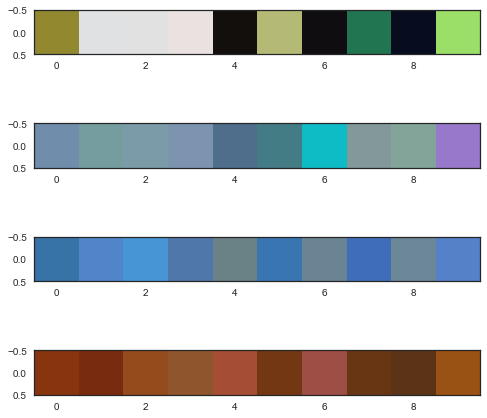

In [683]:
fig(figsize=(8,8))
for idx,output, modes in zip(range(len(selectedOutput)), selectedOutput, selectedModes):
    plt.subplot(len(selectedOutput),1,idx+1)
    plt.imshow(np.array(output[modes[0:10]],ndmin=3))

### Validate

In [477]:
validateFileNames = map(lambda x: x[0], groupedImages['winter'])
validateImages = [ndimage.imread(imageName,mode='RGB') for imageName in validateFileNames]
shuffle(validateImages)

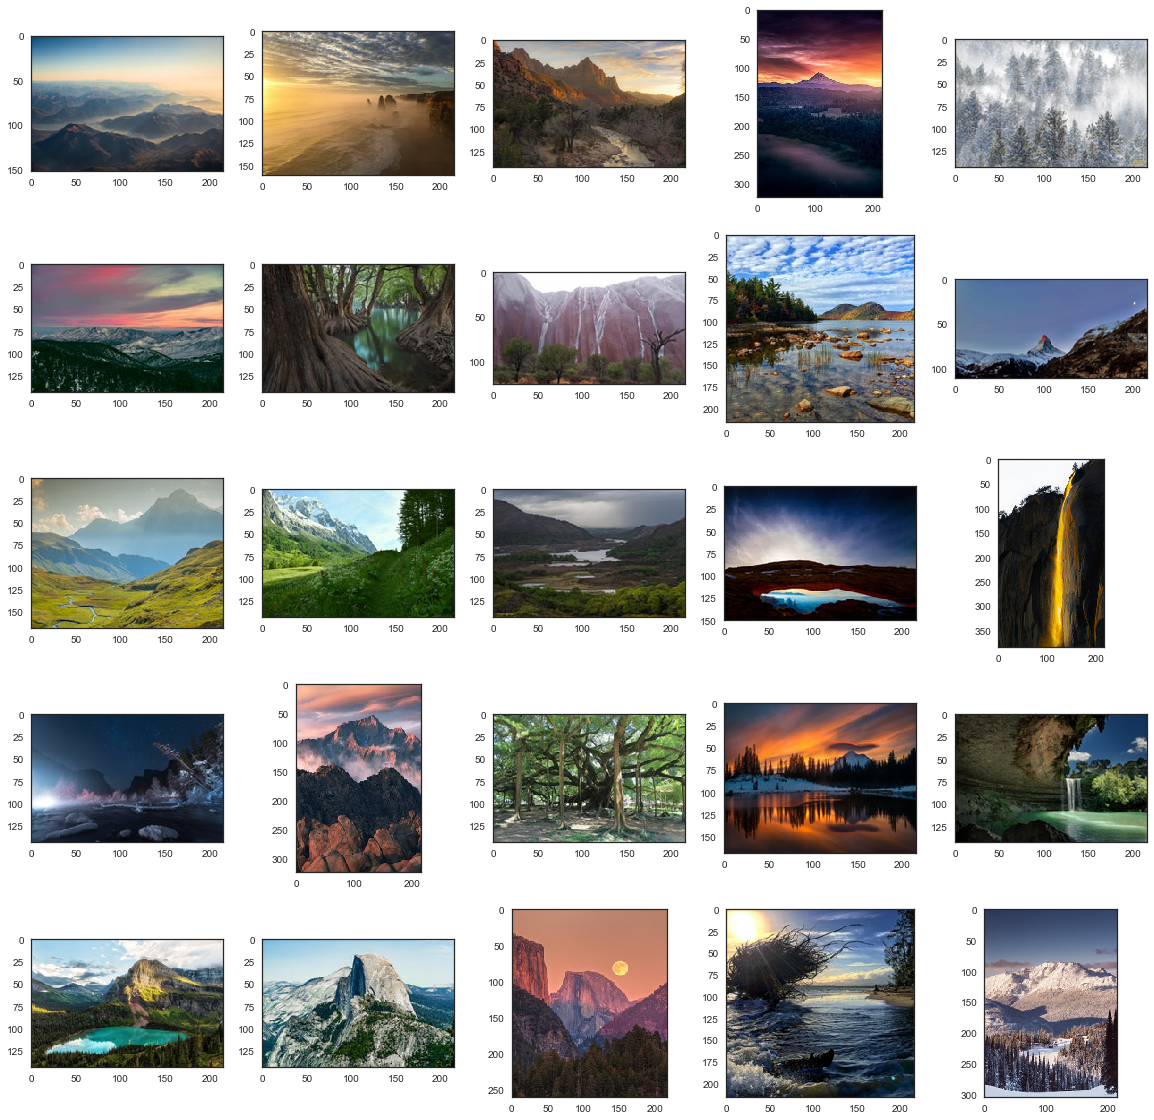

In [478]:
fig(figsize=(20,20))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(validateImages[idx])

### Old Stuff

In [16]:
ratio_output = hsv_to_rgb(np.squeeze(np.array(str_map(parseOutput)(kMeans_output))))

In [17]:
ratio_output.shape

(379, 100, 3)

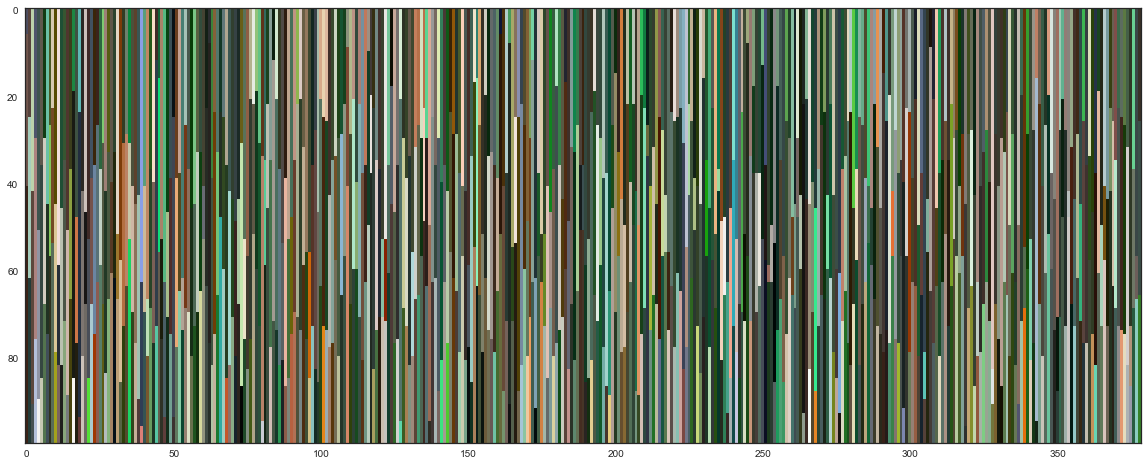

In [18]:
fig(figsize=(20,8))
plt.imshow(np.swapaxes(ratio_output,0,1),aspect='auto')

In [ ]:
map(lambda x: '201610' in x , imageFiles).index(True)